In [165]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import mglearn

In [166]:
transcripts = pd.read_csv("debate_transcripts.csv", engine="python")
transcripts.shape

(4810, 5)

In [167]:
transcripts.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didn’t miss anything. It’s a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0


## Speaker and Time

In [168]:
len(np.unique(transcripts.speaker))

94

In [169]:
total = transcripts.groupby('speaker').agg(
    total_seconds = pd.NamedAgg(column="speaking_time_seconds", aggfunc="sum")
)
total_desc = total.sort_values(by="total_seconds", ascending=False)

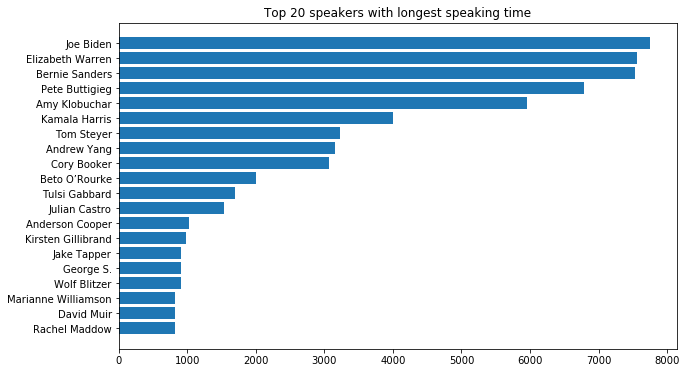

In [170]:
names = np.array(total_desc.index)[:20][::-1]
seconds = np.array(total_desc['total_seconds'])[:20][::-1]

plt.figure(figsize=(10,6))
plt.barh(range(len(names)), seconds, tick_label = names)
plt.title("Top 20 speakers with longest speaking time")
plt.show()

## Section and Time

In [171]:
len(np.unique(transcripts.debate_section))

17

In [172]:
total = transcripts.groupby('debate_section').agg(
    total_seconds = pd.NamedAgg(column="speaking_time_seconds", aggfunc="sum")
)

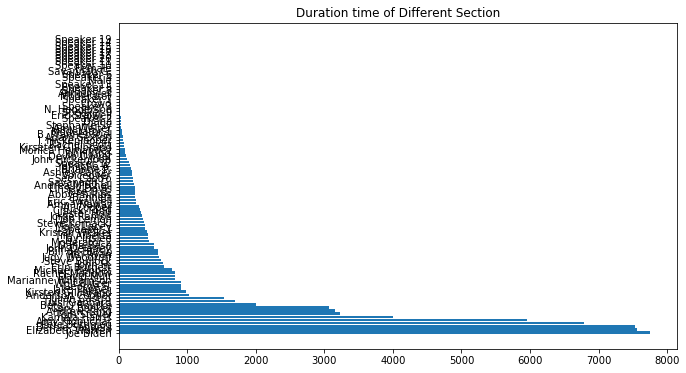

In [173]:
names = np.array(total_desc.index)
seconds = np.array(total_desc['total_seconds'])

plt.figure(figsize=(10,6))
plt.barh(range(len(names)), seconds, tick_label = names)
plt.title("Duration time of Different Section")
plt.show()

## Bag of Words

In [174]:
def clean_str(x):
    z = "".join([y for y in x if y in string.printable])
    return z.translate(str.maketrans("", "", string.punctuation)).lower()

transcripts.speech = transcripts.speech.apply(clean_str)

In [175]:
speech = list(transcripts.speech)

In [176]:
words = set(reduce(lambda x, y: x + y, [x.split() for x in speech]))

In [177]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

freq = dict()
for doc in speech:
    for word in doc.split():
        if word not in ENGLISH_STOP_WORDS:
            freq[word] = freq.get(word, 0) + 1
freq = [(k, v) for k, v in sorted(freq.items(), key=lambda x:x[1], reverse=True)]
freq[:25]

[('people', 1390),
 ('president', 1207),
 ('senator', 1155),
 ('going', 1120),
 ('thank', 922),
 ('country', 748),
 ('want', 706),
 ('just', 687),
 ('think', 664),
 ('right', 664),
 ('thats', 652),
 ('need', 644),
 ('make', 606),
 ('im', 577),
 ('trump', 571),
 ('got', 500),
 ('like', 491),
 ('know', 490),
 ('american', 487),
 ('said', 464),
 ('america', 457),
 ('dont', 449),
 ('way', 443),
 ('time', 405),
 ('say', 402)]

In [178]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words="english", max_df=100)
vect.fit(speech)

X = vect.transform(speech)

In [179]:
X.shape

(4810, 8971)

## Topic modeling and Latent Dirichlet Allocation

In [180]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=16, learning_method="batch",
                               max_iter=25, random_state=0)

document_topics = lda.fit_transform(X)

In [181]:
lda.components_.shape

(16, 8971)

In [182]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [183]:
mglearn.tools.print_topics(topics=range(16), feature_names=feature_names,
                          sorting=sorting, topics_per_chunk=8, n_words=25)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      
secretary     court         women         republicans   orourke       border        williamson    college       
castro        women         congresswoman iowa          sorry         yang          ms            school        
hold          roe           seconds       won           hand          immigration   general       education     
threat        supreme       30            vote          great         rules         crisis        wealth        
bennet        wade          gabbard       immigration   impeachment   asylum        office        kids          
accountable   troops        candidates    voters        oh            undocumented  needs         debt          
iran          says          delaney       corruption    regime        white         department  